# Particle Filtering for Robust Point Correspondence and F matrix estimation

# Part I: Simulate view of scene with perspective projection

In [1]:
import helpers
import numpy as np
from helpers import projectPoints, transformCamera
from math import sin, cos, pi

In [2]:
# Define n random points in 1x1x1 cube centred at (0,0,2): 

n_corr = 20

# p = np.random.rand(n,3)*2 - 1.0 + np.array([[0,0,2.0]])

p = 1000.0 * np.array([[ 0.47729982,  0.46821197,  2.82519478],
                       [ 0.42268141, -0.24521877,  1.35673245],
                       [-0.01436486,  0.47451121,  2.54364829],
                       [ 0.22221251, -0.67802847,  2.48401469],
                       [ 0.53139288,  0.98989222,  1.90058383],
                       [ 0.26739713, -0.57282862,  2.08571485],
                       [-0.00420308, -0.8873651 ,  2.30317347],
                       [ 0.95345022, -0.45281222,  1.64367242],
                       [-0.43965872, -0.42929066,  2.8768967 ],
                       [-0.03042594, -0.44432101,  2.00269752],
                       [-0.27269807, -0.61922827,  2.9905221 ],
                       [ 0.33509766, -0.42812641,  2.17759225],
                       [-0.6597356 , -0.65676217,  1.78080565],
                       [ 0.79502118,  0.42769441,  2.68382864],
                       [-0.70730296,  0.2737345 ,  2.23520083],
                       [ 0.44392226,  0.32736849,  1.82209446],
                       [-0.71203014,  0.04881414,  2.67555491],
                       [ 0.54053719, -0.77533631,  1.12262847],
                       [-0.03883526,  0.44478417,  2.47103904],
                       [ 0.94593446,  0.01870913,  2.37024429]])

In [3]:
# Define camera parameters

f  = 50          # focal length
bu = bv = 20     # scaling factors
u0 = v0 = 0     # offsets

# Define camera position (0, 0, 0) 
cam_pos = np.array([0.0, 0.0, 0.0])

# Define camera orientation in world coordinates (aligned to world, rows are i, j, k vectors)
cam_or = np.eye(3)

In [4]:
u, v = projectPoints(p, cam_pos, cam_or, f, bu, bv, u0, v0)

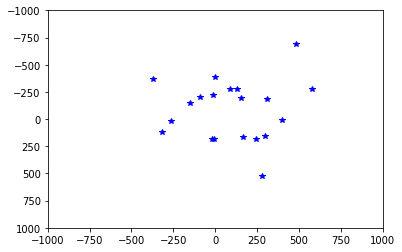

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot(u, v, 'b*')
plt.axis([-bu*f, bu*f, -bv*f, bv*f])
plt.gca().invert_yaxis()
plt.show()

## Interactive display of view from different camera positions and orientations 

In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(transformCamera, p=fixed(p), display=fixed(True),
         x     = (-2000.0, +2000.0, 10.0), 
         y     = (-2000.0, +2000.0, 10.0), 
         z     = (-2000.0, +2000.0, 10.0),
         roll  = ( -pi,  +pi, 0.01),   
         pitch = ( -pi,  +pi, 0.01),   
         yaw   = ( -pi,  +pi, 0.01),
         f=fixed(1), bu=fixed(1), bv=fixed(1), u0=fixed(0), v0=fixed(0)
        ) 

A Jupyter Widget

<function helpers.transformCamera>

-------------------------
# Part II: Particle Filter with TR as E matrix (assume K = I)

1. Set up two camera positions (translation and rotation)
2. Sample possible translation and rotation in 3 dimensions each, using particle filtering

## Set up two camera positions 

In [7]:
from helpers import cartesianToSpherical

# Set up diff in (x, y, z, r, p, y) between the two cameras, and (f, b) for each
diff = np.array([2000.0, -700.0, 1000.0, 0.5, -0.4, -1.0])
z1   = 300.0

f1   = 50
f2   = 50
b1   = 20
b2   = 20

pts1 = transformCamera(p, display=False, x=0, y=0, z=z1, roll=0, pitch=0, yaw=0, 
                       f=f1, bu=b1, bv=b1)
pts2 = transformCamera(p, display=False, x=diff[0], y=diff[1], z=z1+diff[2], 
                       roll=diff[3], pitch=diff[4], yaw=diff[5], 
                       f=f2, bu=b2, bv=b2)

# Add noise points
num_noise = 5
pts1 = np.concatenate((pts1, f1*b1*(np.random.rand(num_noise, 2)*2 - 1.0)), axis = 0)
pts2 = np.concatenate((pts2, f2*b2*(np.random.rand(num_noise, 2)*2 - 1.0)), axis = 0)

# Quantise image points to 3 d.p.
pts1 = np.around(pts1,3)
pts2 = np.around(pts2,3)

# In spherical coordinates
r, theta, phi = cartesianToSpherical(diff[0], diff[1], diff[2])
diff_sph = np.array([theta, phi, diff[3], diff[4], diff[5]])

### List pts1 and pts2:

In [9]:
# Points are fixed for debugging at the moment
pts1 = f1*b1*np.array([[ 0.189, 0.185], [ 0.4 , -0.232], [-0.006, 0.211], [ 0.102, -0.31 ], [ 0.332, 0.618], [ 0.15 , -0.321], [-0.002, -0.443], [ 0.71 , -0.337], [-0.171, -0.167], [-0.018, -0.261], [-0.101, -0.23 ], [ 0.178, -0.228], [-0.446, -0.444], [ 0.334, 0.179], [-0.365, 0.141], [ 0.292, 0.215], [-0.3 , 0.021], [ 0.657, -0.943], [-0.018, 0.205], [ 0.457, 0.009], [ 0.789, 0.955], [ 0.048, 0.33 ], [-0.956, -0.838], [-0.346, 0.23 ], [ 0.641, -0.765]], dtype='float32')
pts2 = f2*b2*np.array([[ 0.423, 0.509], [-0.421, 0.485], [ 0.17 , 0.507], [ 0.075, 0.022], [ 0.162, 1.138], [-0.067, 0.119], [-0.069, -0.037], [-0.134, 0.306], [ 0.083, 0.106], [-0.145, 0.196], [ 0.13 , 0.026], [ 0.01 , 0.179], [-0.332, 0.138], [ 0.521, 0.578], [-0.088, 0.417], [-0.021, 0.711], [ 0.022, 0.282], [-0.73 , 0.161], [ 0.136, 0.506], [ 0.412, 0.443], [-0.491, 0.086], [-0.135, -0.912], [-0.321, 0.002], [ 0.6 , -0.35 ], [ 0.428, -0.009]], dtype='float32')

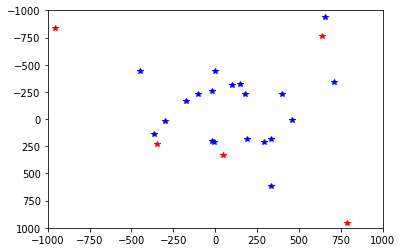

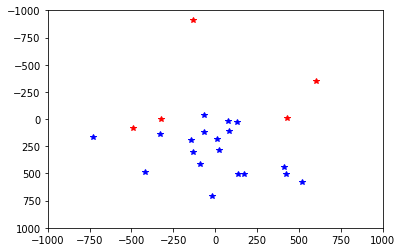

([-1000, 1000, -1000, 1000], None, None)

In [10]:
# Display pts1 and pts2
plt.plot(pts1[:n_corr, 0], pts1[:n_corr, 1], 'b*'), plt.plot(pts1[n_corr:, 0], pts1[n_corr:, 1], 'r*')
plt.axis([-bu*f, bu*f, -bv*f, bv*f]), plt.gca().invert_yaxis(), plt.show()
plt.plot(pts2[:n_corr, 0], pts2[:n_corr, 1], 'b*'), plt.plot(pts2[n_corr:, 0], pts2[n_corr:, 1], 'r*')
plt.axis([-bu*f, bu*f, -bv*f, bv*f]), plt.gca().invert_yaxis(), plt.show()

## 2. Run Particle Filter

In [97]:
from importlib import reload
reload(helpers)

<module 'helpers' from 'D:\\Courses\\NUS\\DCVPC\\code\\helpers.py'>

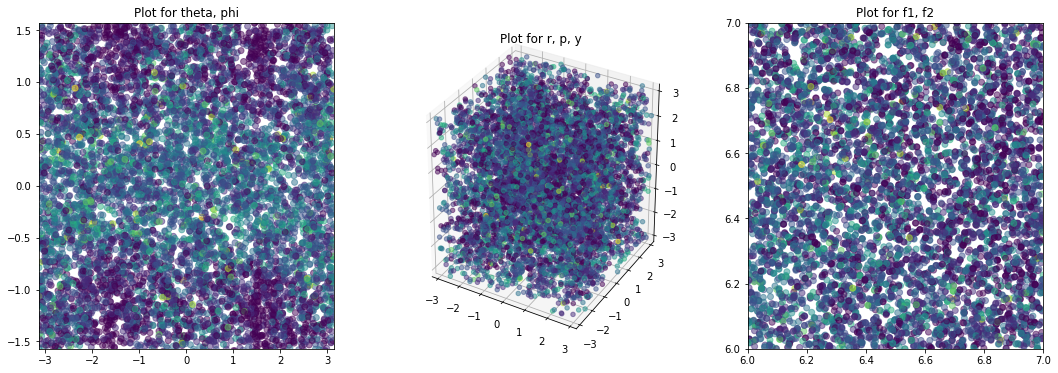

First 200 scores: [3, 0, 0, 2, 4, 5, 5, 3, 1, 3, 4, 2, 0, 0, 2, 2, 2, 1, 3, 3, 6, 3, 0, 4, 4, 0, 0, 4, 1, 1, 1, 0, 3, 2, 0, 0, 4, 4, 0, 4, 2, 4, 0, 3, 2, 1, 1, 0, 3, 0, 0, 4, 3, 1, 0, 5, 2, 1, 1, 0, 0, 0, 4, 2, 2, 4, 0, 0, 1, 5, 2, 4, 0, 0, 3, 2, 0, 1, 1, 0, 2, 4, 4, 2, 1, 2, 0, 0, 3, 1, 1, 2, 3, 1, 6, 3, 1, 4, 1, 1, 4, 1, 3, 0, 1, 1, 2, 4, 1, 4, 4, 3, 3, 0, 0, 2, 1, 2, 1, 0, 1, 3, 3, 3, 3, 5, 2, 1, 3, 0, 0, 3, 0, 2, 0, 1, 0, 1, 3, 2, 2, 0, 1, 3, 5, 2, 6, 2, 0, 1, 2, 0, 2, 1, 1, 2, 4, 4, 2, 0, 2, 4, 3, 4, 3, 2, 3, 0, 5, 3, 1, 4, 0, 0, 0, 1, 2, 3, 3, 1, 1, 4, 2, 1, 0, 5, 4, 1, 1, 0, 1, 2, 4, 3, 0, 3, 3, 0, 3, 3]
Non-match ratio: 0.965070 (14809/15345)
Sigma: ['0.080000', '0.080000', '0.080000', '0.080000', '0.080000', '0.001000', '0.001000']
Epsilon: 5.000000
Iteration: 1
Elapsed time: 11.592316s


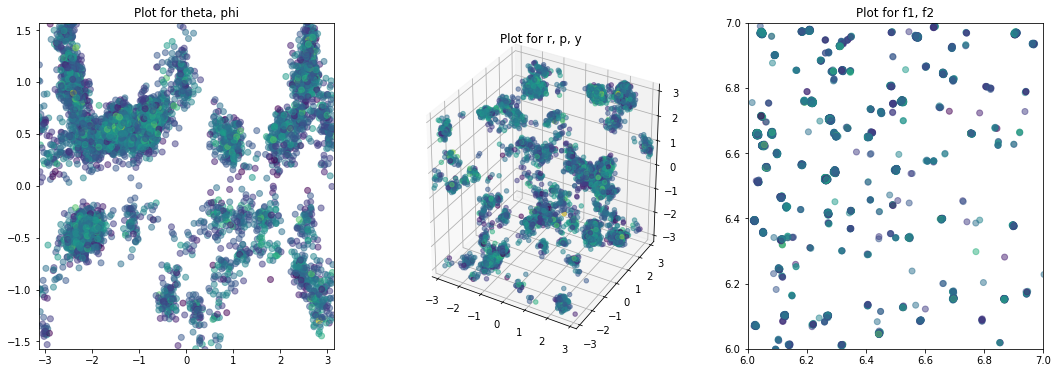

First 200 scores: [7, 4, 3, 2, 3, 5, 3, 3, 2, 8, 7, 4, 3, 1, 5, 5, 6, 4, 2, 7, 3, 3, 3, 3, 7, 5, 6, 3, 5, 6, 5, 6, 5, 7, 2, 3, 6, 6, 6, 4, 3, 4, 4, 6, 7, 5, 5, 5, 1, 4, 4, 4, 7, 6, 4, 6, 5, 6, 5, 4, 5, 5, 1, 1, 6, 6, 5, 4, 4, 4, 6, 4, 4, 2, 6, 3, 6, 7, 5, 6, 4, 4, 3, 4, 4, 5, 4, 3, 1, 4, 2, 5, 6, 4, 6, 3, 6, 2, 4, 4, 3, 7, 3, 2, 4, 4, 5, 5, 6, 3, 5, 4, 7, 2, 4, 4, 5, 3, 5, 4, 3, 4, 7, 6, 3, 5, 8, 3, 3, 2, 2, 8, 3, 7, 3, 6, 3, 5, 7, 4, 6, 4, 5, 6, 3, 3, 3, 4, 4, 2, 5, 2, 5, 3, 3, 4, 3, 2, 3, 4, 5, 5, 2, 2, 5, 4, 3, 0, 4, 4, 4, 3, 7, 5, 5, 6, 5, 3, 8, 2, 5, 9, 6, 3, 3, 5, 5, 4, 5, 5, 7, 4, 6, 5, 5, 5, 5, 4, 5, 1]
Non-match ratio: 0.957471 (33410/34894)
Sigma: ['0.064000', '0.064000', '0.064000', '0.064000', '0.064000', '0.000800', '0.000800']
Epsilon: 5.000000
Iteration: 6
Elapsed time: 58.662056s


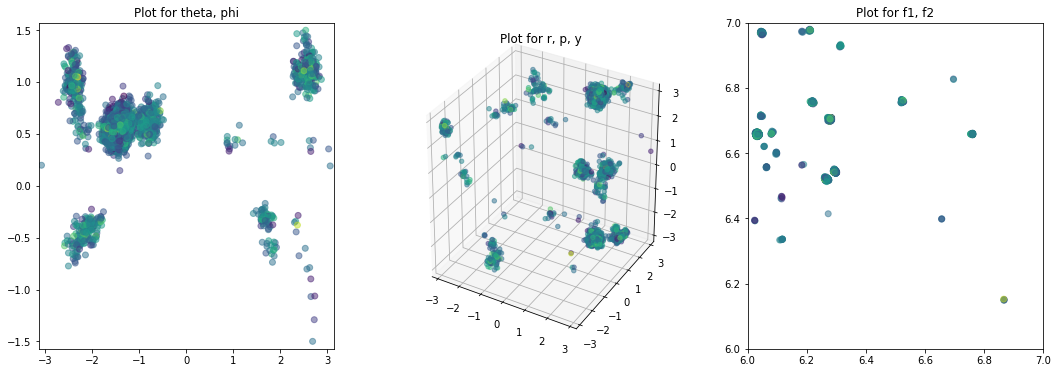

First 200 scores: [4, 2, 3, 5, 5, 5, 7, 4, 5, 4, 7, 4, 5, 4, 5, 4, 4, 4, 4, 5, 5, 5, 4, 6, 4, 6, 5, 5, 3, 4, 4, 9, 6, 3, 7, 5, 5, 6, 5, 6, 3, 7, 6, 7, 3, 4, 4, 5, 6, 4, 5, 7, 5, 5, 5, 7, 4, 6, 5, 6, 6, 8, 5, 3, 5, 7, 5, 3, 7, 4, 4, 3, 7, 3, 5, 7, 6, 4, 4, 5, 5, 5, 6, 4, 6, 4, 6, 7, 7, 7, 6, 5, 7, 6, 5, 3, 4, 2, 3, 2, 6, 5, 7, 4, 3, 5, 6, 4, 3, 6, 6, 4, 5, 5, 7, 4, 7, 4, 7, 5, 6, 7, 6, 7, 6, 4, 7, 7, 6, 6, 8, 4, 1, 5, 7, 5, 5, 6, 4, 3, 5, 4, 2, 5, 5, 5, 4, 7, 7, 6, 4, 5, 4, 6, 4, 6, 6, 4, 5, 6, 4, 3, 4, 7, 7, 6, 5, 4, 6, 4, 7, 4, 5, 6, 5, 5, 5, 6, 5, 8, 3, 5, 4, 5, 5, 5, 5, 4, 8, 5, 5, 4, 4, 6, 7, 8, 3, 6, 4, 4]
Non-match ratio: 0.953988 (39767/41685)
Sigma: ['0.051200', '0.051200', '0.051200', '0.051200', '0.051200', '0.000640', '0.000640']
Epsilon: 5.000000
Iteration: 11
Elapsed time: 106.134996s


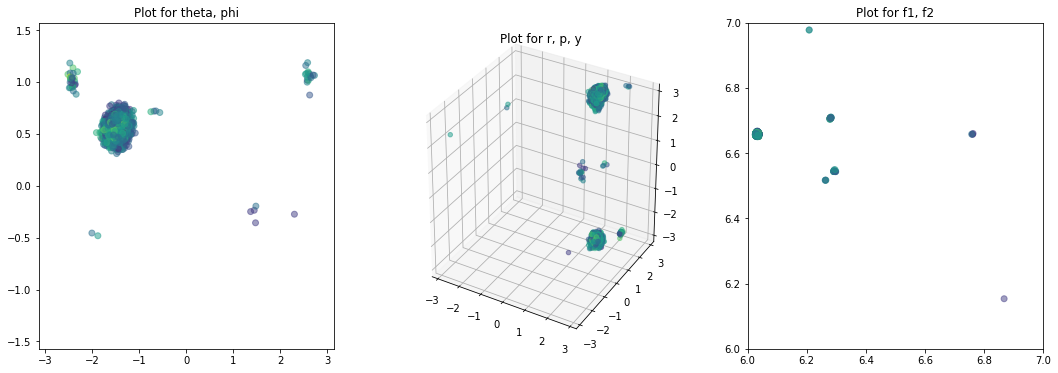

First 200 scores: [5, 3, 7, 4, 3, 7, 6, 8, 3, 4, 6, 5, 3, 6, 3, 7, 8, 4, 6, 6, 2, 5, 8, 5, 7, 4, 9, 9, 5, 7, 5, 6, 7, 6, 3, 7, 5, 7, 5, 6, 4, 6, 5, 5, 4, 4, 6, 7, 5, 9, 5, 4, 8, 3, 2, 7, 4, 7, 7, 6, 7, 6, 5, 8, 7, 4, 4, 4, 5, 6, 3, 3, 10, 7, 6, 4, 6, 5, 5, 5, 6, 4, 6, 5, 5, 1, 5, 6, 6, 5, 5, 5, 6, 4, 7, 6, 4, 4, 6, 7, 5, 5, 7, 5, 10, 5, 6, 4, 5, 6, 6, 6, 5, 4, 6, 4, 4, 6, 5, 8, 6, 5, 4, 7, 5, 6, 7, 8, 6, 5, 5, 7, 7, 6, 3, 6, 4, 6, 6, 9, 6, 5, 7, 5, 6, 7, 7, 7, 7, 5, 2, 5, 6, 5, 2, 7, 5, 6, 4, 5, 5, 4, 7, 9, 5, 5, 6, 8, 7, 7, 7, 3, 7, 8, 10, 5, 4, 6, 6, 5, 6, 5, 4, 7, 2, 5, 7, 6, 5, 6, 8, 5, 5, 4, 7, 7, 4, 4, 4, 5]
Non-match ratio: 0.955321 (41973/43936)
Sigma: ['0.040960', '0.040960', '0.040960', '0.040960', '0.040960', '0.000512', '0.000512']
Epsilon: 5.000000
Iteration: 16
Elapsed time: 153.521101s


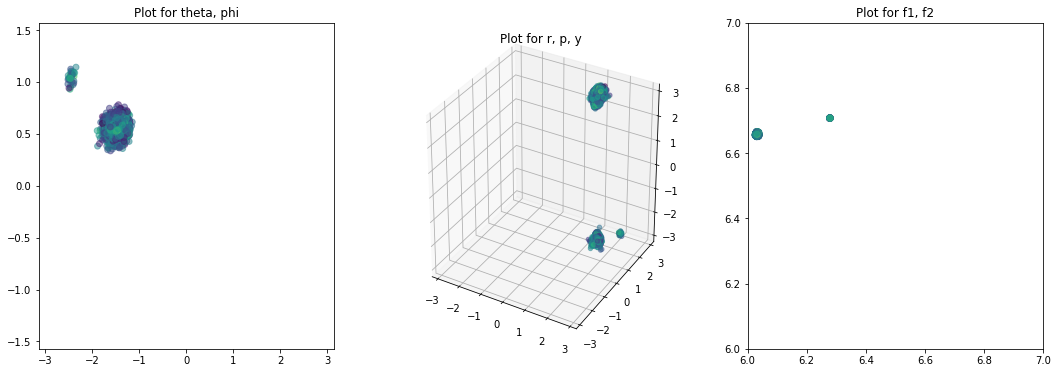

First 200 scores: [6, 7, 5, 6, 5, 3, 6, 5, 6, 3, 5, 7, 7, 6, 5, 6, 5, 5, 6, 5, 5, 9, 4, 7, 6, 5, 5, 6, 5, 6, 3, 5, 6, 7, 6, 7, 5, 5, 5, 5, 6, 5, 6, 3, 6, 2, 5, 3, 3, 3, 6, 7, 8, 4, 9, 6, 4, 6, 7, 5, 5, 6, 8, 6, 7, 5, 4, 6, 4, 6, 7, 7, 3, 5, 6, 6, 6, 8, 5, 7, 6, 7, 6, 5, 6, 6, 5, 7, 5, 6, 5, 9, 6, 7, 7, 3, 5, 7, 8, 5, 6, 6, 7, 7, 7, 5, 2, 6, 4, 8, 5, 4, 5, 7, 3, 4, 5, 3, 5, 8, 6, 6, 6, 11, 7, 7, 3, 6, 8, 6, 5, 6, 7, 7, 3, 7, 5, 6, 3, 5, 7, 4, 7, 6, 5, 5, 6, 7, 6, 5, 6, 6, 6, 7, 5, 5, 7, 6, 5, 8, 8, 4, 7, 4, 6, 4, 4, 4, 3, 5, 9, 5, 5, 4, 3, 4, 2, 6, 9, 5, 10, 5, 3, 8, 6, 7, 6, 5, 7, 6, 6, 6, 7, 8, 5, 6, 9, 3, 4, 6]
Non-match ratio: 0.955924 (43702/45717)
Sigma: ['0.032768', '0.032768', '0.032768', '0.032768', '0.032768', '0.000410', '0.000410']
Epsilon: 5.000000
Iteration: 21
Elapsed time: 200.742931s


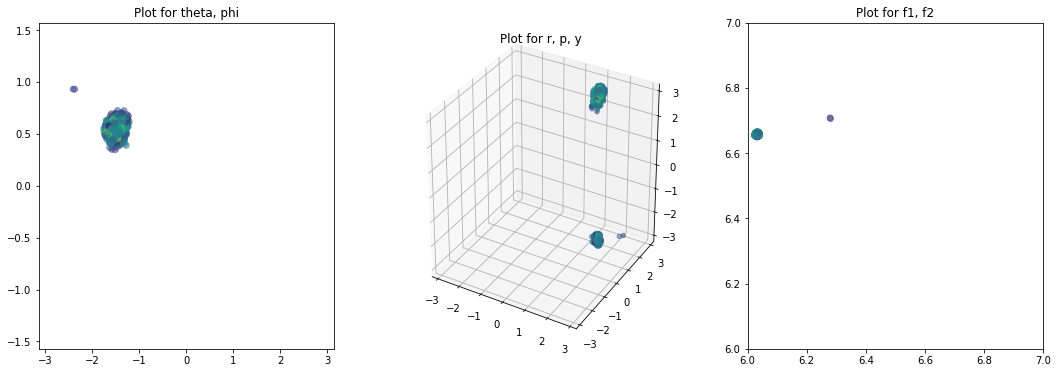

First 200 scores: [5, 9, 3, 8, 7, 9, 5, 6, 6, 3, 6, 7, 6, 8, 4, 8, 7, 4, 5, 7, 5, 5, 8, 9, 7, 5, 10, 7, 6, 7, 6, 4, 7, 6, 6, 5, 7, 6, 7, 8, 8, 8, 3, 8, 7, 5, 7, 5, 9, 4, 7, 5, 3, 6, 5, 5, 5, 2, 6, 2, 7, 6, 5, 4, 7, 4, 7, 8, 5, 4, 5, 6, 6, 7, 3, 6, 5, 4, 7, 5, 4, 6, 3, 6, 10, 5, 7, 4, 5, 6, 8, 6, 7, 4, 4, 5, 8, 7, 4, 3, 5, 7, 5, 7, 3, 4, 6, 5, 7, 6, 7, 6, 8, 6, 4, 7, 6, 6, 6, 4, 6, 8, 10, 5, 8, 9, 7, 8, 5, 6, 8, 3, 9, 5, 5, 7, 3, 6, 7, 5, 6, 6, 4, 7, 5, 8, 4, 6, 7, 7, 3, 7, 4, 8, 7, 10, 7, 4, 4, 5, 6, 3, 6, 6, 4, 7, 7, 11, 9, 7, 4, 6, 7, 6, 6, 4, 7, 6, 3, 7, 8, 5, 8, 3, 8, 9, 8, 9, 6, 7, 7, 8, 6, 6, 6, 8, 7, 7, 8, 5]
Non-match ratio: 0.963599 (46829/48598)
Sigma: ['0.026214', '0.026214', '0.026214', '0.026214', '0.026214', '0.000328', '0.000328']
Epsilon: 5.000000
Iteration: 26
Elapsed time: 246.823617s


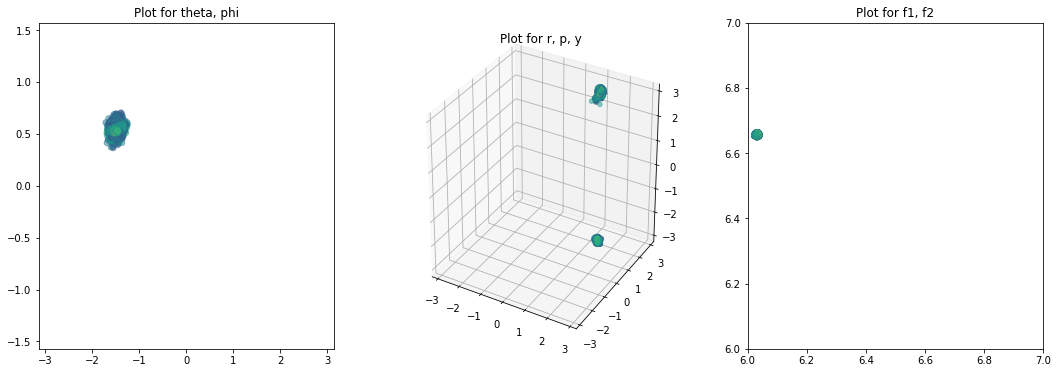

First 200 scores: [5, 7, 4, 3, 3, 5, 7, 8, 8, 5, 7, 4, 5, 4, 6, 5, 6, 6, 5, 7, 4, 7, 5, 7, 6, 8, 7, 8, 3, 8, 6, 9, 6, 7, 4, 7, 4, 8, 10, 7, 7, 9, 6, 4, 8, 3, 5, 9, 6, 6, 2, 7, 5, 6, 5, 7, 5, 9, 6, 10, 7, 5, 6, 8, 5, 8, 5, 8, 7, 5, 3, 4, 6, 8, 7, 6, 7, 9, 7, 6, 4, 7, 7, 5, 8, 9, 6, 7, 8, 7, 4, 5, 6, 6, 5, 7, 8, 5, 5, 7, 6, 7, 7, 8, 5, 7, 7, 6, 6, 2, 2, 4, 4, 8, 4, 4, 4, 8, 5, 6, 7, 4, 6, 5, 8, 6, 7, 7, 6, 6, 5, 8, 9, 5, 5, 8, 7, 6, 7, 8, 7, 6, 2, 6, 6, 5, 7, 5, 7, 6, 5, 8, 5, 4, 8, 3, 9, 9, 7, 7, 7, 8, 6, 4, 6, 7, 6, 7, 5, 7, 8, 3, 6, 6, 8, 3, 6, 8, 8, 3, 9, 5, 4, 8, 4, 9, 5, 9, 6, 6, 4, 5, 6, 8, 3, 5, 4, 5, 7, 2]
Non-match ratio: 0.966354 (47935/49604)
Sigma: ['0.026214', '0.026214', '0.026214', '0.026214', '0.026214', '0.000328', '0.000328']
Epsilon: 5.000000
Iteration: 30
Elapsed time: 284.369844s


In [99]:
from helpers import ParticleFilter, generateSamples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time
from math import log

start_time = time.time()
# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 30
m = 8000

# Set range to be a uniform cube of length 1 around the solution
# ranges = np.array([[*diff_sph-0.5, 1/m], [*diff_sph+0.5, 1/m]]).T  

ranges = np.array([[-pi, pi],
                   [-pi/2, pi/2],
                   [-pi, pi], 
                   [-pi, pi], 
                   [-pi, pi], 
                   [6, 7],
                   [6, 7],
                   [1/m, 1/m]])

e = 5
sigma = np.array([*[0.08]*5, # sigma_angles
                  *[0.001]*2]  # sigma_log(fk)
                ) 

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.8
sigma_interval = 5 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 1 #0.5
e_interval = 5

# ---------------------------------------------------------

S_new = generateSamples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, n_corr, epsilon = e, epipole_t = 0.3, norm_mode = "softmax")
    
    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (18,6))

        ax1 = fig.add_subplot(131)
        ax1.scatter(*S_new[:2,:], c= score_list, alpha=0.5)
        ax1.set_xlim(*ranges[0])
        ax1.set_ylim(*ranges[1])
        ax1.set_title("Plot for theta, phi")
        
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.scatter(*S_new[2:5,:], c= score_list, alpha=0.5)
        ax2.set_xlim3d(*ranges[2])
        ax2.set_ylim3d(*ranges[3])
        ax2.set_zlim3d(*ranges[4])
        ax2.set_title("Plot for r, p, y")
        
        if S_new.shape[0] == 8:
            ax3 = fig.add_subplot(133)
            ax3.scatter(*S_new[5:7,:], c= score_list, alpha=0.5)
            ax3.set_xlim(*ranges[5])
            ax3.set_ylim(*ranges[6])
            ax3.set_title("Plot for f1, f2")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % ((nmc/mc if mc else 0), nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
        print("Elapsed time: %fs" % (time.time() - start_time))
        
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor

## 3. Recover solution from Particle Filter
- Visually inspect number of clusters and find their centroids

In [100]:
# Print average
ave = np.average(S_new[:-1, :], axis = 1)
print("Average:      " + str(ave))
print("Ground truth: " + str(diff_sph))

Average:      [-1.48744385  0.54069463  1.37852296  1.94965911  1.66379666  6.03176095
  6.65691582]
Ground truth: [-0.33667482  1.12985649  0.5        -0.4        -1.        ]


[[-1.48014383  0.54144219  1.3787089   1.95346407  3.05709071  6.03164492
   6.65696283]
 [-1.51240908  0.53813806  1.37788706  1.93664656 -3.10111507  6.03215778
   6.65675506]]


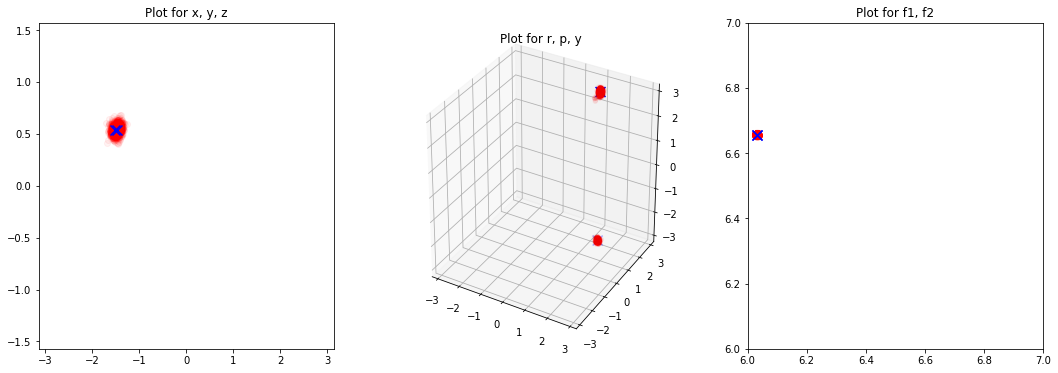

In [101]:
# Retrieve clusters
from sklearn.cluster import KMeans

num_clusters = 2

kmeans_model = KMeans(n_clusters = num_clusters).fit(S_new[:-1, :].T)
results = kmeans_model.cluster_centers_
print(results)

res = results.T

fig = plt.figure(figsize = (18,6))
ax1 = fig.add_subplot(131)
ax1.scatter(*S_new[:2,:m//4], c='red', alpha=0.05)
ax1.scatter(*res[:2,:], c='blue', marker='x', s=100)
ax1.set_xlim(*ranges[0])
ax1.set_ylim(*ranges[1])
ax1.set_title("Plot for x, y, z")

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(*S_new[2:5,:m//4], c='red', alpha=0.05)
ax2.scatter(*res[2:5,:], zdir='z', c='blue', marker='x', s=100)
ax2.set_xlim3d(*ranges[2])
ax2.set_ylim3d(*ranges[3])
ax2.set_zlim3d(*ranges[4])
ax2.set_title("Plot for r, p, y")

if S_new.shape[0] == 8:
    ax3 = fig.add_subplot(133)
    ax3.scatter(*S_new[5:7,:m//4], c='red', alpha=0.05)
    ax3.scatter(*res[5:,:], c='blue', marker='x', s=100)
    ax3.set_xlim(*ranges[5])
    ax3.set_ylim(*ranges[6])
    ax3.set_title("Plot for f1, f2")
            
plt.show()

## 4. Check solution

In [102]:
# Compare rotation with ground truth by taking modulo wrt. 2pi
np.set_printoptions(suppress=True)

gt = np.array([*diff_sph]) % (2*pi)
for res_idx in range(results.shape[0]):
    r = results[res_idx, :5] % (2*pi)
    print("Solution r:   " + str(r))
    print("Ground truth: " + str(gt))

    diff_r = np.minimum((r - gt) % (2*pi), (gt - r) % (2*pi))
    print("Difference:   " + str((np.around(diff_r,8))))
    print()
    
np.set_printoptions(suppress=None)

Solution r:   [4.80304147 0.54144219 1.3787089  1.95346407 3.05709071]
Ground truth: [5.94651049 1.12985649 0.5        5.88318531 5.28318531]
Difference:   [1.14346901 0.5884143  0.8787089  2.35346407 2.22609459]

Solution r:   [4.77077623 0.53813806 1.37788706 1.93664656 3.18207024]
Ground truth: [5.94651049 1.12985649 0.5        5.88318531 5.28318531]
Difference:   [1.17573426 0.59171842 0.87788706 2.33664656 2.10111507]



In [105]:
# Construct E from solution t and r, check that (pts1)' E (pts2) = 0

from helpers import rpy2R, xyz2T, sphericalToCartesian

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

E_products = []
for res_idx in range(results.shape[0]):
    t  = sphericalToCartesian(1, *results[res_idx, :2])
    r  = results[res_idx, 2:]
    
    T = xyz2T(t[0], t[1], t[2])
    R = rpy2R(r[0], r[1], r[2])
    
    E_product = []
    for i in range(pts1_uvf.shape[0]):
        E_product.append(pts1_uvf[i, :] @ T @ R @ pts2_uvf[i, :].T)
    E_products.append(E_product)

# for res in E_products:
#     for pt in res:
#         print(pt)
#     print()

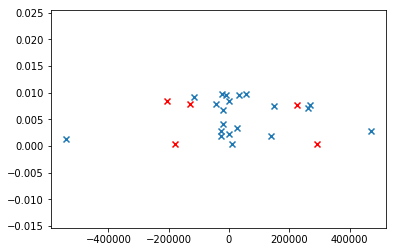

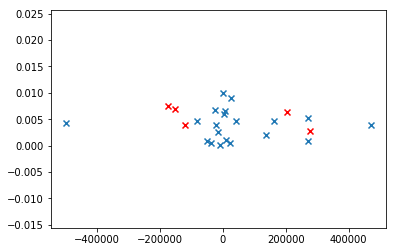

In [106]:
# Visualise (pts1)' E (pts2)

for i in E_products:
    plt.scatter(i[:n_corr], np.random.rand(len(i[:n_corr]))*0.01, marker='x') # perturb vertically to see 
    plt.scatter(i[n_corr:], np.random.rand(len(i[n_corr:]))*0.01, marker='x', color='r') 
    plt.show()

## 5. Check ground truth solution with (pts1)' E (pts2) = 0 for comparison

In [94]:
from helpers import rpy2R, xyz2T

t = np.array(diff)

T = xyz2T(t[0], t[1], t[2])
R = rpy2R(t[3], t[4], t[5])
E = np.dot(T, R)

a1 = f1*b1
a2 = f2*b2 

A1 = np.array([[1/a1, 0, 0],[0, 1/a1, 0],[0, 0, 1]])
A2 = np.array([[1/a2, 0, 0],[0, 1/a2, 0],[0, 0, 1]])

E = A1 @ E @ A2

for i in range(pts1_uvf.shape[0]):
    print(pts1_uvf[i, :] @ E @ pts2_uvf[i, :].T)

0.31059326058198167
0.47735237606406145
-0.1736363309250919
0.1327764197791481
1.1473768140406264
1.2315349495357424
0.25848519204933496
-0.2852449462028517
1.6698738980893495
0.6342895693780406
-0.2692657966882166
0.520300962359272
2.0286596103286456
-0.2841926524099563
0.5952755934241623
0.05751986361656236
-1.3931206852168998
0.886459176426456
-0.9351554464010405
0.26809577555627584
-2094.9712259638773
-3058.7339432634076
345.04985348070886
-1223.9231447498555
1070.9736999599663
